## Fitness/Environment Dimensionality Reduction Exploration
### 2021-02-11

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Load data:

In [2]:
dat = np.load('FinalPopulationAndEnv1000runs_2_20_21.npz')

Examine objects:

```
finalpopulations: final populations as a 1000x10x10 matrix (runnumber, bethedge, drift)
envifull: Full environment plot. Percent of organisms that die in given bin on each day as a 1000x100x50 (runnumber, bin, day)
envimean: Only the mean of the environment per day (i.e. which bin is the peak) 1000x50 (run, day)
y_prefvariancemesh: the bethedging values corresponding to the heatmaps
x_driftvariancemesh: the drift values corresponding to the heatmap
```

In [3]:
dat_files = dat.files
{f: dat[f].shape for f in dat_files}

{'finalpopulations': (1000, 10, 10),
 'envifull': (1000, 100, 50),
 'envimean': (1000, 50),
 'y_prefvariancemesh': (11,),
 'x_driftvariancemesh': (11,)}

In [4]:
finalpopulations = dat['finalpopulations']
envifull = dat['envifull']
envimean = dat['envimean']
y_prefvariancemesh = dat['y_prefvariancemesh']
x_driftvariancemesh = dat['x_driftvariancemesh']

Take a look at one of the entries in `finalpopulations`:

In [5]:
# from here: https://github.com/athena-ye/Simplified-Drift-Modeling/blob/master/driftmodeling.ipynb
bh_range = np.linspace(0, 2, 10)
drift_range = np.linspace(0, 0.2, 10)

bh_series = pd.Series(bh_range.round(2), name='BH')
drift_series = pd.Series(drift_range.round(2), name='drift')

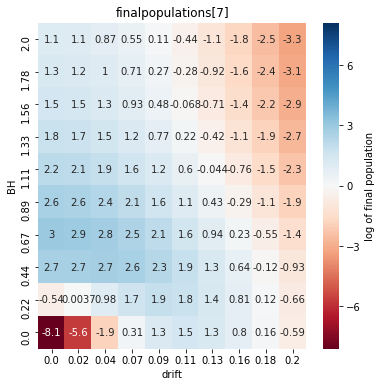

In [6]:
example_i = 7

example_pop_matrix = finalpopulations[example_i]

# take log
log_matrix = np.log(example_pop_matrix)

# make a pandas dataframe
plot_log_df = pd.DataFrame(log_matrix, 
                           index=bh_series, columns=drift_series)
# reorder rows so that y axis is increasing in the heatmap
plot_log_df = plot_log_df.iloc[::-1, :]

vmag = np.max(np.abs((log_matrix.min(), log_matrix.max())))
plt.figure(figsize=(6,6))
plt.title(f'finalpopulations[{example_i}]')
sns.heatmap(plot_log_df, cmap='RdBu', 
            vmin=-vmag, vmax=vmag,
            annot=True,
            cbar_kws = {'label': 'log of final population'})
plt.show()

Taking cues from Athena's code, tried to reproduce log final population matrices often shown in lab meeting.

Take a look at `envifull`:

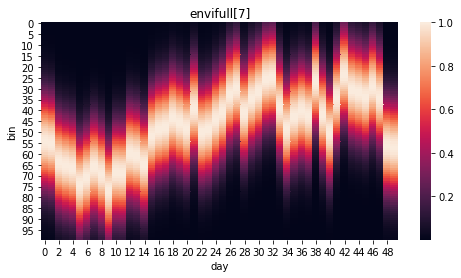

In [7]:
example_i = 7

plt.figure(figsize=(8,4))
plt.title(f'envifull[{example_i}]')
sns.heatmap(envifull[example_i])
plt.xlabel('day')
plt.ylabel('bin')
plt.show()

Within a run, the bin with the maximum for each day in `envifull` is what's in `envimean` -- yay:

In [8]:
np.argmax(envifull[example_i], 0)

array([55, 55, 64, 66, 67, 74, 71, 66, 70, 77, 69, 69, 60, 61, 65, 52, 49,
       48, 44, 46, 48, 39, 50, 49, 44, 41, 33, 30, 41, 35, 32, 26, 25, 39,
       49, 43, 40, 43, 27, 42, 50, 34, 24, 31, 32, 34, 29, 34, 57, 57],
      dtype=int64)

In [9]:
envimean[example_i]

array([55., 55., 64., 66., 67., 74., 71., 66., 70., 77., 69., 69., 60.,
       61., 65., 52., 49., 48., 44., 46., 48., 39., 50., 49., 44., 41.,
       33., 30., 41., 35., 32., 26., 25., 39., 49., 43., 40., 43., 27.,
       42., 50., 34., 24., 31., 32., 34., 29., 34., 57., 57.])

## environment metrics

Now let's define some measure of the environment for each run:
- the mean, across days, of the daily environment means
- the standard deviation, across days, of the daily environment means

In [10]:
env_mean_mean = envimean.mean(1)
env_mean_std = envimean.std(1)

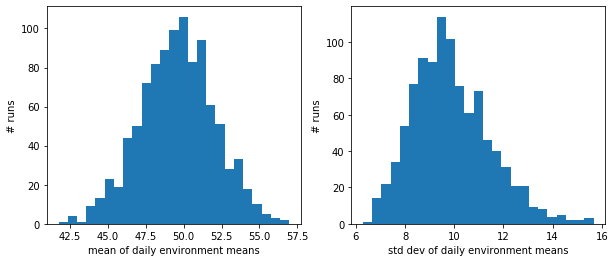

In [11]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.hist(env_mean_mean, bins=25)
plt.xlabel('mean of daily environment means')
plt.ylabel('# runs')

plt.subplot(122)
plt.hist(env_mean_std, bins=25)
plt.xlabel('std dev of daily environment means')
plt.ylabel('# runs')
plt.show()

## run metrics

Now let's define some measures of each 10x10 fitness matrix:
- the bin position along the BH axis of the largest final population in the 10x10 matrix
- the bin position along the drift axis of the largest final population in the 10x10 matrix

In [12]:
def row_col_argmax(a):
    '''
    Given a 2-D array a,
    returns the row index + column index
    of the array's maximum
    from here: https://stackoverflow.com/a/9483964
    '''
    return np.unravel_index(a.argmax(), a.shape)

In [13]:
n_runs, n_bethedging, n_drift = finalpopulations.shape

In [14]:
finalpopulation_argmaxes = np.array([row_col_argmax(fp) for fp in finalpopulations])
bh_argmaxes = finalpopulation_argmaxes[:, 0]
drift_argmaxes = finalpopulation_argmaxes[:, 1]

color_bh = bh_argmaxes / np.max(bh_argmaxes)
color_drift = drift_argmaxes / np.max(drift_argmaxes)
color_array = [(color_bh[i], 0, color_drift[i]) for i in range(n_runs)]

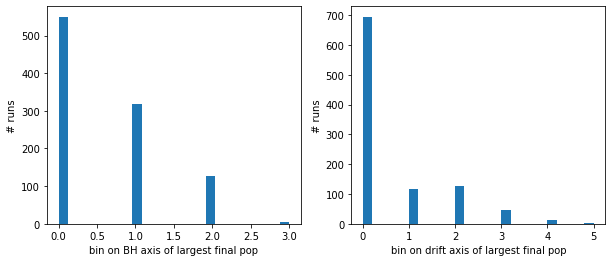

In [15]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.hist(bh_argmaxes, bins=25)
plt.xlabel('bin on BH axis of largest final pop')
plt.ylabel('# runs')

plt.subplot(122)
plt.hist(drift_argmaxes, bins=25)
plt.xlabel('bin on drift axis of largest final pop')
plt.ylabel('# runs')
plt.show()

## Visualizations of all runs in low-dimensional space

Make a data matrix of size 1000 x 100:

In [16]:
X = finalpopulations.reshape((n_runs, n_bethedging * n_drift))
X_centered = X - X.mean(0)

## t-SNE

In [17]:
from sklearn.manifold import TSNE

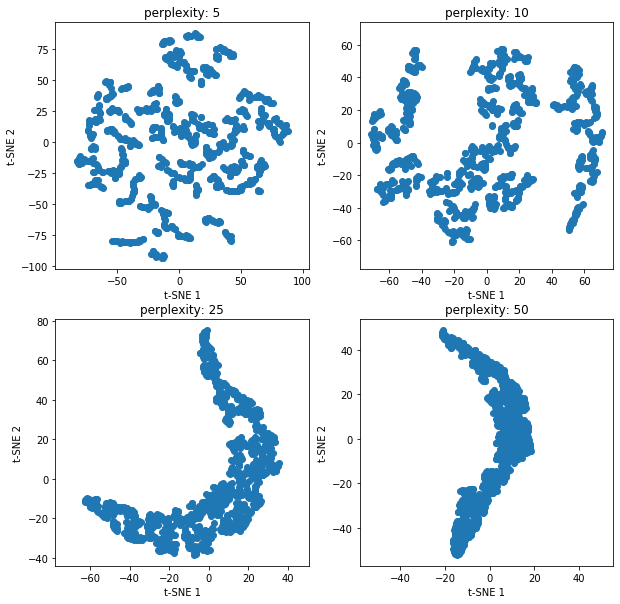

In [18]:
perplexities = [5, 10, 25, 50]

plt.figure(figsize=(10, 10))

for i in range(4):
    cur_perplexity = perplexities[i]
    
    Y_tsne = TSNE(perplexity=cur_perplexity).fit_transform(X_centered)

    plt.subplot(2, 2, i+1)
    plt.title(f'perplexity: {cur_perplexity}')
    plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1])
    plt.axis('equal')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
        
plt.show()

At low perplexity of 5, we get many disjoint islands. Once perplexity hits 25, there's a pretty stable worm-like manifold. 

Let's pick a perplexity of 25 and try coloring the points by various aspects.

In [19]:
chosen_perplexity = 25
Y_tsne = TSNE(perplexity=chosen_perplexity).fit_transform(X_centered)

Let's color by environmental variables: the mean of the daily environment mean bins, and the standard deviation of the daily environment mean bins:

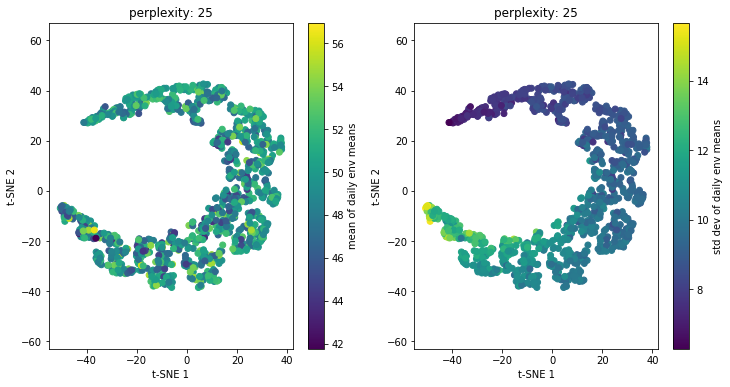

In [20]:
cm = plt.cm.get_cmap('RdBu')

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title(f'perplexity: {chosen_perplexity}')
sc = plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], 
                 c=env_mean_mean)
plt.colorbar(sc, label='mean of daily env means')
plt.axis('equal')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')

plt.subplot(122)
plt.title(f'perplexity: {chosen_perplexity}')
sc = plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], 
                 c=env_mean_std)
plt.colorbar(sc, label='std dev of daily env means')
plt.axis('equal')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.show()

Runs that have similar variabilities in their daily environmental means seem to land close together onto the low-D space.

Now let's try coloring by run aspects: the bin along the BH (or drift) axis containing the largest final population:

In [21]:
color_array_R_only = [(x[0], 0, 0) for x in color_array]
color_array_B_only = [(0, 0, x[0]) for x in color_array]

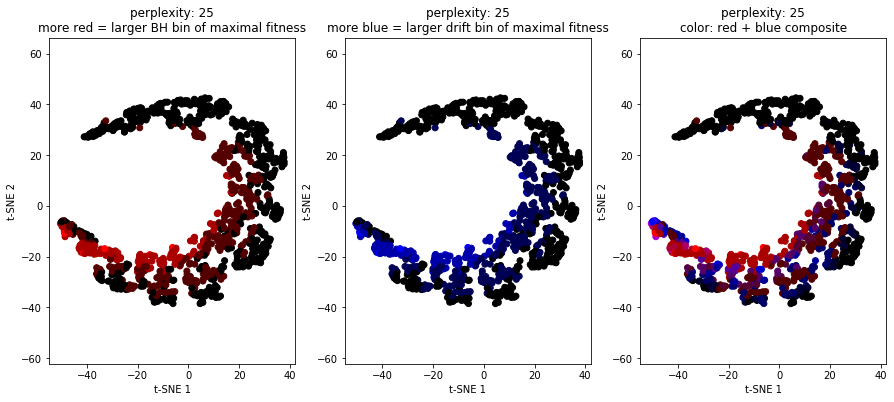

In [22]:
plt.figure(figsize=(15,6))

plt.subplot(131)
plt.title(f'perplexity: {chosen_perplexity}\nmore red = larger BH bin of maximal fitness')
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=color_array_R_only)
plt.axis('equal')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')

plt.subplot(132)
plt.title(f'perplexity: {chosen_perplexity}\nmore blue = larger drift bin of maximal fitness')
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=color_array_B_only)
plt.axis('equal')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')

plt.subplot(133)
plt.title(f'perplexity: {chosen_perplexity}\ncolor: red + blue composite')
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=color_array)
plt.axis('equal')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')

plt.show()

## UMAP

Now let's try the default UMAP setting, coloring by the standard deviation in daily environmental means:

In [23]:
import umap

In [24]:
um = umap.UMAP()
Y_umap = um.fit_transform(X_centered)

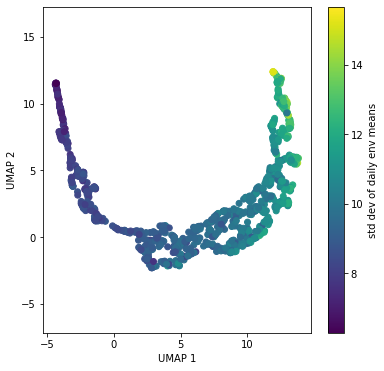

In [25]:
plt.figure(figsize=(6,6))
sc = plt.scatter(Y_umap[:, 0], Y_umap[:, 1], c=env_mean_std)
plt.colorbar(sc, label='std dev of daily env means')
plt.axis('equal')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')
plt.show()

The low-D picture looks similar to what we had above in the t-SNE. The default number of neighbors in UMAP is 15, similar to the perplexity of 25 chosen above for t-SNE.

In [26]:
um

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=15, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)